### 【 D0127_Mini-Project_이준기 】

- 민원 처리 (NLP)
- 텍스트 -> Task 분류

In [45]:
## 모듈 로딩
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

import pandas as pd

In [46]:
## 딥러닝 모듈 로딩
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
from   torch.optim.lr_scheduler import ReduceLROnPlateau

from   torch.utils.data import Dataset, TensorDataset, DataLoader
from   torch.utils.data import random_split
from   sklearn.model_selection import train_test_split

import util_func as uf

import pandas as pd

In [47]:
## 데이터 준비
DATA_FILE = '../Project/PrData/train.csv'

df = pd.read_csv(DATA_FILE)

df.nunique()

NUM_CLASSES = df['label'].nunique()

In [48]:
## 전처리 함수 생성
from konlpy.tag import Okt
import re

okt = Okt()

stopwords = ['합니다', '바랍니다', '부탁', '요청', '제발', '주세요', '하십시오']

def preprocessing(text):
    text = re.sub('[^가-힣 ]', ' ', text) # 한글 + 공백만 남기기

    nouns = okt.nouns(text)

    nouns = [word for word in nouns if word not in stopwords and len(word) > 1]

    return ' '.join(nouns)

In [49]:
## 전처리 잘 되는지 임시 텍스트로 테스트해보기
# text = "초등학교 바로 근처에 피부샵 간판에 '브라질리언'이라고 써있으니 초등생 아이가 그게 뭐냐고 물어봅니다. 선뜻 대답하기 어려웠고 요즘 아이들은 거의 다 스마트폰이 있으니 검색해 보고 음란 사진에 접할까 봐 염려되니 제재 바랍니다."

# text = preprocessing(text)

# print(text)

In [50]:
## 전처리 적용
df['clean_text'] = df['text'].apply(preprocessing)

In [51]:
df_s = df.iloc[:, 1:]
df_s

,label,clean_text
0,건축허가,창원시 의창구 주소 불법 건축물 행정 조치
1,건축허가,창원시 의창구 주소 불법 건축물 조치
2,건축허가,창원시 의창구 주소 불법 건축물 대해 법적 조치
3,건축허가,경남 창원시 마산회원구 주소 삼거리 불법 부착 현수막 가까이 미관 보기 철거
4,건축허가,경남 창원시 마산회원구 주소 삼거리 불법 부착 현수막 가까이 미관 보기 철거 시오
...,...,...
799995,환경미화,진해시 환경 후반 여성 직원 문의
799996,환경미화,진해시 환경 이름 직원
799997,환경미화,진해시 직원 하나 후반 여성 환경 근무
799998,환경미화,환경 후반 이름 직원 근무


In [52]:
print(df_s.shape)

(800000, 2)


In [53]:
## ----------------------------------------------------------
## 비율 확인
## ----------------------------------------------------------
df_s['clean_text'].value_counts(normalize=True)

clean_text
횡단보도 불법 정차 차량 신고 단속         0.003782
교차로 모퉁이 불법 정차 차량 신고 단속      0.002150
횡단보도 불법 정차 차량 신고            0.002110
창원시 횡단보도 불법 정차 신고           0.001874
창원시 횡단보도 불법 정차 처리           0.001399
                              ...   
진해시 환경 후반 여성 직원 문의          0.000001
진해시 환경 이름 직원                0.000001
진해시 직원 하나 후반 여성 환경 근무       0.000001
환경 후반 이름 직원 근무              0.000001
직원 하나 후반 여성 직원 진해시 환경 근무    0.000001
Name: proportion, Length: 478514, dtype: float64

In [54]:
## 타겟 컬럼 라벨 인코딩
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_s['label_idx'] = le.fit_transform(df_s['label'])


In [55]:
from collections import Counter

counter = Counter()
for text in df_s['clean_text']:
    counter.update(text.split())

vocab = {word: idx+2 for idx, (word, _) in enumerate(counter.most_common())}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

VOCAB_SIZE = len(vocab)
print("VOCAB SIZE:", VOCAB_SIZE)


VOCAB SIZE: 21992


In [56]:
MAX_LEN = 50

def text_to_seq(text):
    return [vocab.get(word, 1) for word in text.split()]

def pad_seq(seq, max_len=MAX_LEN):
    return seq[:max_len] + [0] * (max_len - len(seq))

df_s['seq'] = df_s['clean_text'].apply(text_to_seq)
df_s['seq_pad'] = df_s['seq'].apply(pad_seq)


In [57]:
## ----------------------------------------------------------
## 데이터 나누기
## ----------------------------------------------------------
featureDF = pd.DataFrame(df_s['seq_pad'].to_list())
targetDF  = df_s[['label_idx']]

In [58]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

BS      = 64
EPOCHS = 10
LR     = 1e-3
MAX_LEN = 50

In [59]:
class TextDataset(Dataset):

    def __init__(self, featureDF, targetDF):
        self.xTS = torch.tensor(featureDF.values, dtype=torch.long)
        self.yTS = torch.tensor(targetDF.values.squeeze(), dtype=torch.long)
        self.length = featureDF.shape[0]

    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        return self.xTS[idx], self.yTS[idx]


In [60]:
x_train, x_valid, y_train, y_valid = train_test_split(
    featureDF,
    targetDF,
    test_size=0.2,
    random_state=10,
    stratify=targetDF
)

trainDS = TextDataset(x_train, y_train)
validDS = TextDataset(x_valid, y_valid)

trainDL = DataLoader(trainDS, batch_size=BS, shuffle=True)
validDL = DataLoader(validDS, batch_size=BS)


In [61]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)     # (B, T, E)
        _, (h, _) = self.lstm(x)
        out = self.fc(h[-1])      # (B, C)
        return out


In [62]:
model = TextClassifier(
    vocab_size=VOCAB_SIZE,
    embed_dim=128,
    hidden_dim=128,
    num_classes=NUM_CLASSES
).to(DEVICE)

loss_fn   = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)


In [63]:
history = {
    "train_loss": [],
    "val_loss": [],
    "train_f1": [],
    "val_f1": []
}


In [64]:
from sklearn.metrics import f1_score

BEST_F1 = 0.0

for epoch in range(EPOCHS):

    # ======================
    # Train
    # ======================
    model.train()
    train_loss = 0
    y_true, y_pred = [], []

    for x, y in trainDL:
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)

        preds = torch.argmax(logits, dim=1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

    train_loss /= len(trainDL.dataset)
    train_f1 = f1_score(y_true, y_pred, average="macro")

    # ======================
    # Validation
    # ======================
    model.eval()
    valid_loss = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for x, y in validDL:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            loss = loss_fn(logits, y)

            valid_loss += loss.item() * x.size(0)

            preds = torch.argmax(logits, dim=1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    valid_loss /= len(validDL.dataset)
    valid_f1 = f1_score(y_true, y_pred, average="macro")

    history["train_loss"].append(train_loss)
    history["val_loss"].append(valid_loss)
    history["train_f1"].append(train_f1)
    history["val_f1"].append(valid_f1)

    print(
        f"[{epoch+1:02d}] "
        f"LOSS train/valid = {train_loss:.4f} / {valid_loss:.4f} | "
        f"F1 train/valid = {train_f1:.4f} / {valid_f1:.4f}"
    )

    if valid_f1 > BEST_F1:
        BEST_F1 = valid_f1
        torch.save(model.state_dict(), "best_text_model.pth")


[01] LOSS train/valid = 2.0191 / 1.9964 | F1 train/valid = 0.0507 / 0.0461
[02] LOSS train/valid = 1.5788 / 1.0376 | F1 train/valid = 0.1918 / 0.4435
[03] LOSS train/valid = 0.8067 / 0.6919 | F1 train/valid = 0.6019 / 0.6549
[04] LOSS train/valid = 0.6107 / 0.5927 | F1 train/valid = 0.7004 / 0.7149
[05] LOSS train/valid = 0.5043 / 0.5308 | F1 train/valid = 0.7656 / 0.7558
[06] LOSS train/valid = 0.4231 / 0.4835 | F1 train/valid = 0.8086 / 0.7830
[07] LOSS train/valid = 0.3629 / 0.4550 | F1 train/valid = 0.8413 / 0.8025
[08] LOSS train/valid = 0.3168 / 0.4251 | F1 train/valid = 0.8643 / 0.8208
[09] LOSS train/valid = 0.2822 / 0.4020 | F1 train/valid = 0.8811 / 0.8319
[10] LOSS train/valid = 0.2559 / 0.3852 | F1 train/valid = 0.8934 / 0.8437


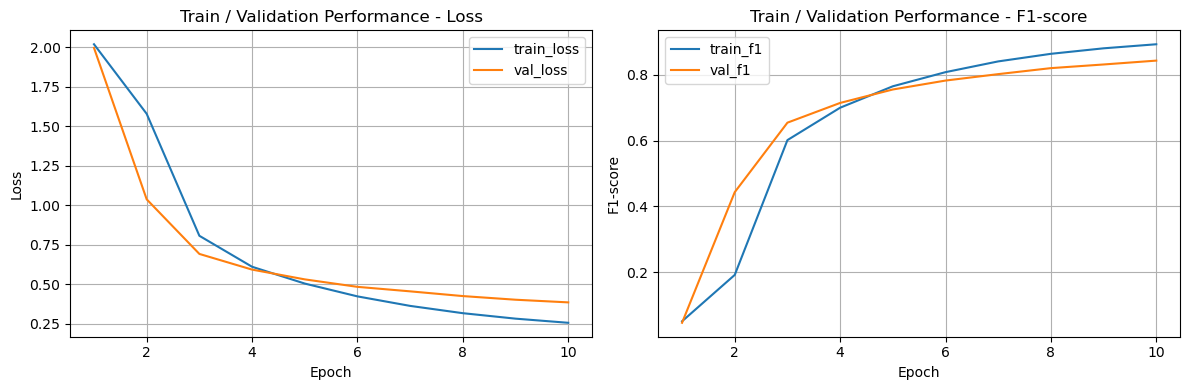

In [72]:
## ----------------------------------------------------------
## 그래프 출력
## ----------------------------------------------------------
uf.plot_history(history, title="Train / Validation Performance")

In [73]:
# test 데이터 로드
test_df = pd.read_csv("../Project/PrData/test.csv")

# 같은 전처리 함수 적용
test_df["clean_text"] = test_df["text"].apply(preprocessing)

test_df = test_df.dropna()
test_df.head()

,text,label,clean_text
0,창원시 의창구 #@주소#에 불법건축물에 대해 빠른 처리 부탁드립니다.,건축허가,창원시 의창구 주소 불법 건축물 대해 처리
1,초등학교 바로 근처에 피부샵 간판에 '브라질리언'이라고 써있으니 초등생 아이가 그게...,건축허가,초등학교 바로 근처 피부 간판 브라질 리언 초등생 아이 그게 선뜻 대답 요즘 아이 ...
2,창원시 성산구 #@주소# 아파트 내진설계에 대해 문의합니다.,건축허가,창원시 성산구 주소 아파트 진설 대해 문의
3,창원시 진해구 불법광고물 철거 요청 드립니다.,건축허가,창원시 진해구 불법 광고 철거
4,창원시 아파트 외부발코니 샷시창호 변경에 대해 문의합니다.,건축허가,창원시 아파트 외부 발코니 샷시 창호 변경 대해 문의


In [ ]:
test_df["label_id"] = le.transform(test_df["label"])


In [ ]:
# train에서 이미 fit된 tokenizer 사용
X_test = tokenizer.texts_to_sequences(test_df["clean_text"])
X_test = pad_sequence(X_test, max_len=MAX_LEN)

y_test = test_df["label_id"].values


In [ ]:
class TextDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [ ]:
testDS = TextDataset(X_test, y_test)
testDL = DataLoader(testDS, batch_size=BS)

In [ ]:
from sklearn.metrics import f1_score, classification_report

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for x, y in testDL:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)

        preds = torch.argmax(logits, dim=1)

        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_f1 = f1_score(y_true, y_pred, average="macro")
print(f"[TEST] F1(macro): {test_f1:.4f}")

print("\n[Classification Report]")
print(classification_report(y_true, y_pred, target_names=le.classes_))
